In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import os

mkdir -p failed for path /afs/csail.mit.edu/u/s/sebodiaz/.config/matplotlib: [Errno 13] Permission denied: '/afs/csail.mit.edu/u/s/sebodiaz/.config/matplotlib'
Matplotlib created a temporary cache directory at /tmp/matplotlib-uf763xqk because there was an issue with the default path (/afs/csail.mit.edu/u/s/sebodiaz/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


This is a notebook to plot my results for the pose estimation test sets.

## Research Dataset

In [5]:
base_path   = "/data/vision/polina/users/sebodiaz/projects/pose_fin/results/inference" # base path where all method folders lie
methods     = ["tm_tmp_trepulse_mean", "zw"] # all the methods of interest
dataset     = "research"
groundtruth = "/data/vision/polina/projects/fetal/common-data/pose/SeboPoseLabel"


# initialize dictionaries to store keypoints for each method
method_predictions = {method: [] for method in methods}
method_groundtruth = []

# loop through each method
for it, method in enumerate(methods):
    # instantiate the path
    path = os.path.join(base_path, method, dataset)
    
    # loop through each subject
    subjects = sorted(os.listdir(path))
    for subject in subjects:
        # load the predicted (and groundtruth) keypoints
        d = scipy.io.loadmat(os.path.join(path, subject))["joint_coord"]
        if it == 0: g = scipy.io.loadmat(os.path.join(groundtruth, subject))["joint_coord"]

        # append
        method_predictions[method].append(d)
        if it == 0: method_groundtruth.append(g)
    
stacked_predictions = {method: np.vstack(method_predictions[method]) for method in methods}
stacked_groundtruth = np.vstack(method_groundtruth)  # Assuming same GT for all methods


In [6]:
def computePCK(predictions, groundtruth, threshold=5):
    """
    Compute the Percentage of Correct Keypoints (PCK) between predicted and ground truth keypoints.

    Args:
        predictions (np.ndarray): Predicted keypoints of shape (T, 3, 15).
        groundtruth (np.ndarray): Ground truth keypoints of shape (T, 3, 15).
        threshold (float): Distance threshold to consider a keypoint correct.

    Returns:
        np.ndarray: PCK score for each keypoint.
    """
    # Compute Euclidean distance per keypoint across T frames
    distances = np.linalg.norm(predictions - groundtruth, axis=1)  # Shape: (T, 15)

    # Determine correctness based on threshold
    correct_keypoints = distances <= threshold  # Boolean array of shape (T, 15)

    # Compute PCK for each keypoint (mean over all time steps)
    pck_per_keypoint = np.mean(correct_keypoints, axis=0)  # Shape: (15,)

    return pck_per_keypoint

In [7]:
pck_scores = {method: computePCK(stacked_predictions[method], stacked_groundtruth) for method in methods}

# Print results
for method, pck in pck_scores.items():
    print('-------------------------')
    print(f"PCK for {method}: {pck}")
    print(f'-- average {pck.mean()} --')

-------------------------
PCK for tm_tmp_trepulse_mean: [0.926632   0.91074523 0.99480069 0.99191219 0.9994223  0.98180243
 0.97631427 0.97833622 0.97891392 0.97573657 0.97429232 0.99855575
 0.9965338  0.90930098 0.91912189]
-- average 0.9674947044097825 --
-------------------------
PCK for zw: [0.9225881  0.92172155 0.99480069 0.99335644 0.99913345 0.98295783
 0.96995956 0.97862507 0.97978047 0.97458117 0.97631427 0.99855575
 0.9971115  0.93327556 0.92923166]
-- average 0.9701328711727325 --


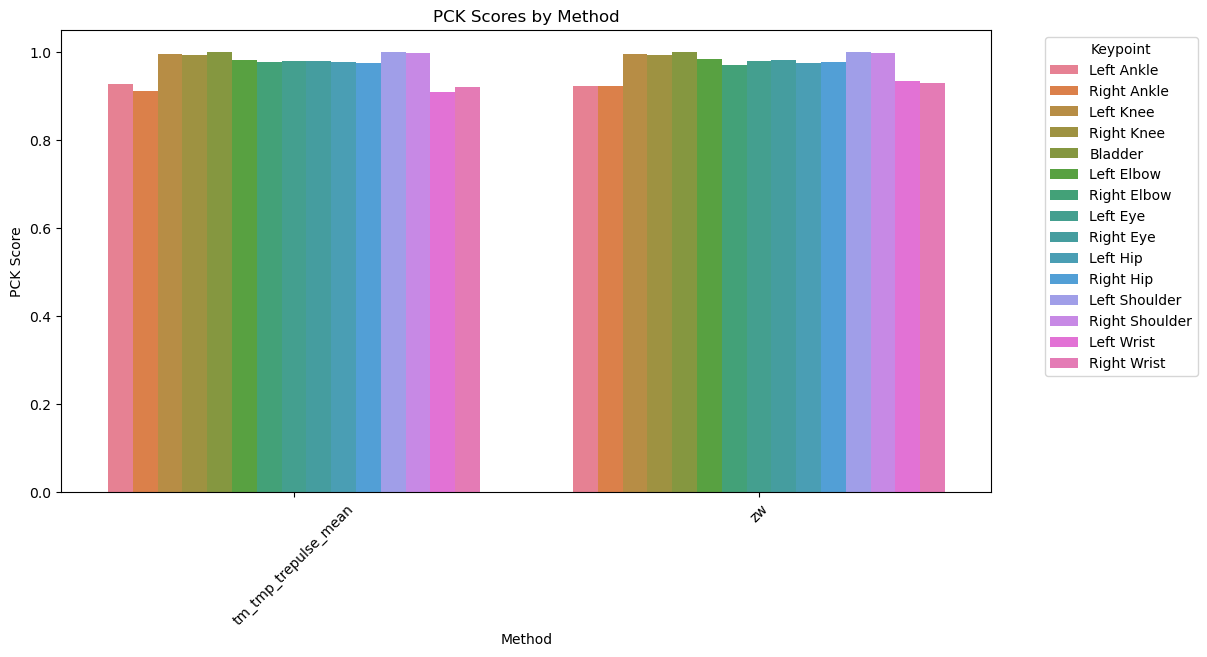

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define keypoint names
keypoint_names = [
    "Left Ankle", "Right Ankle", "Left Knee", "Right Knee", "Bladder",
    "Left Elbow", "Right Elbow", "Left Eye", "Right Eye", "Left Hip",
    "Right Hip", "Left Shoulder", "Right Shoulder", "Left Wrist", "Right Wrist"
]

# Convert PCK scores to a DataFrame
pck_data = []
for method, pck in pck_scores.items():
    for i, score in enumerate(pck):
        pck_data.append({'Method': method, 'Keypoint': keypoint_names[i], 'PCK Score': score})

df = pd.DataFrame(pck_data)

# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Method", y="PCK Score", hue="Keypoint", dodge=True)

# Adjust and show plot
plt.xticks(rotation=45)
plt.title("PCK Scores by Method")
plt.legend(title="Keypoint", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()